# Ideal Parameter Analysis ($\delta=2.25$, $\tau=1.25$, $\alpha=1.75$) ($\alpha$ lower edge)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=1.75

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

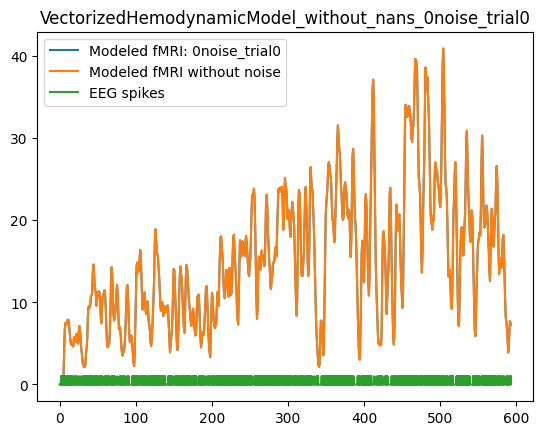

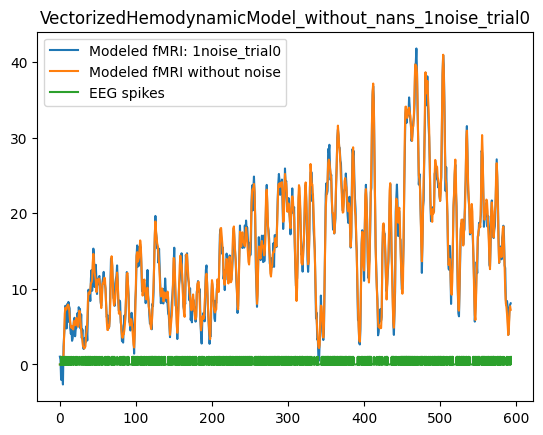

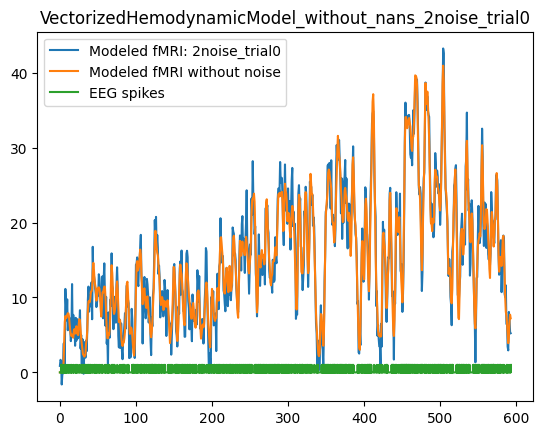

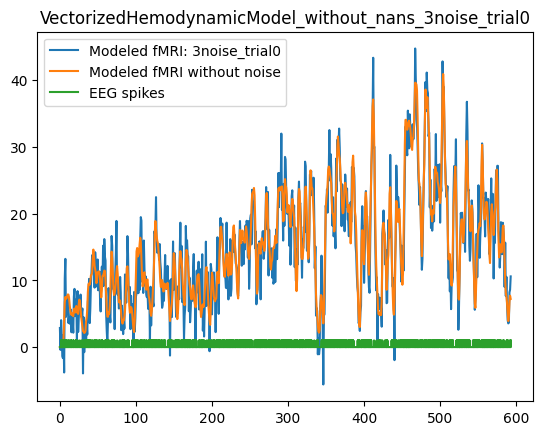

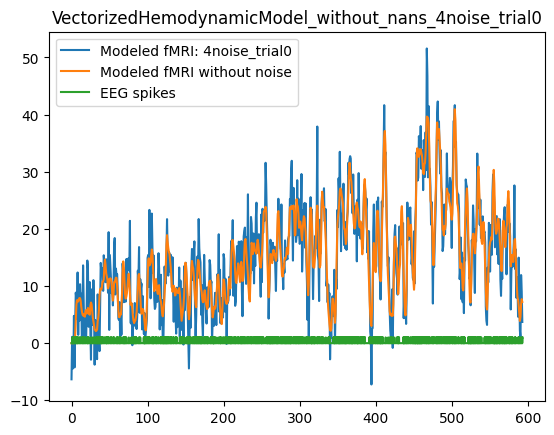

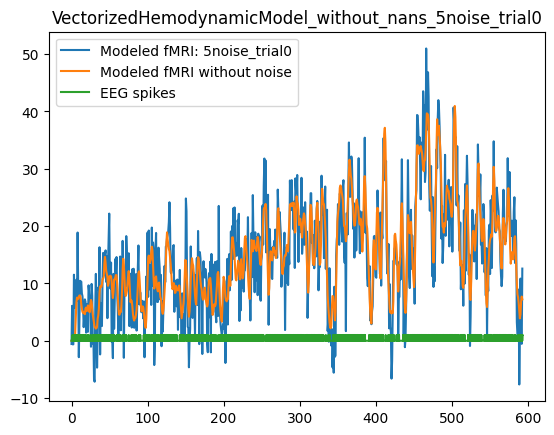

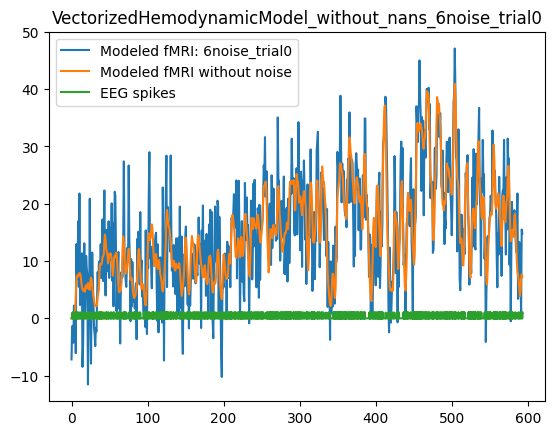

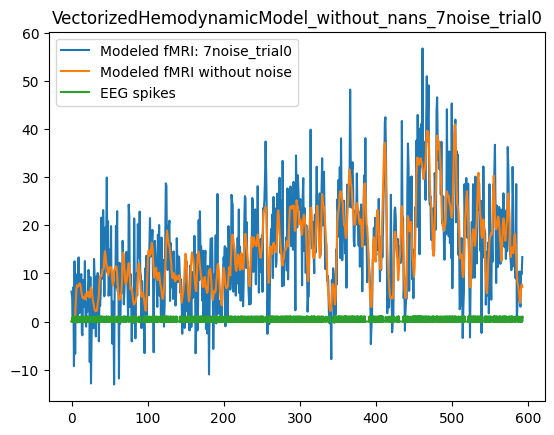

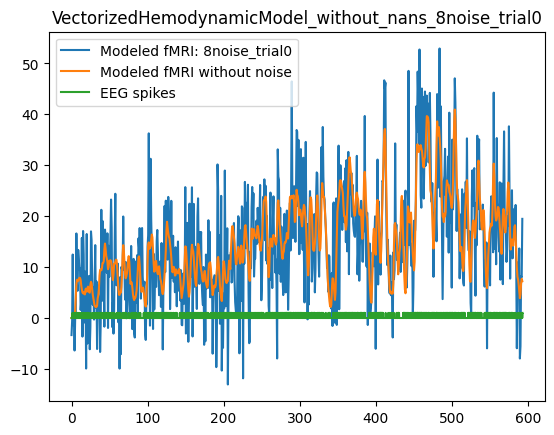

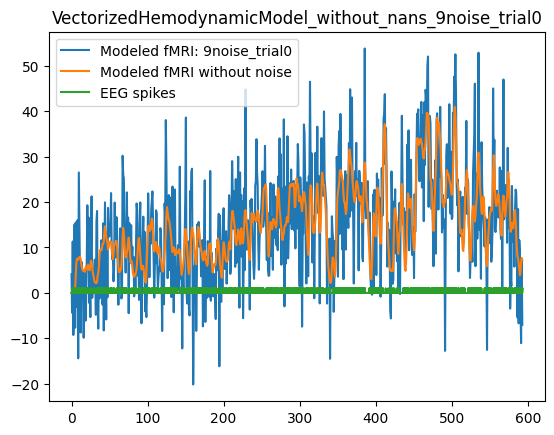

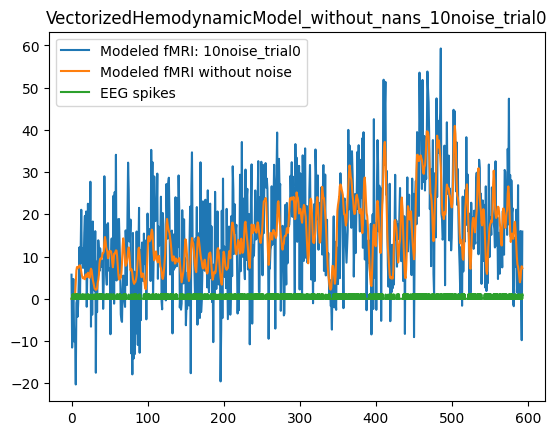

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 1.75, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.25, alpha=1.75


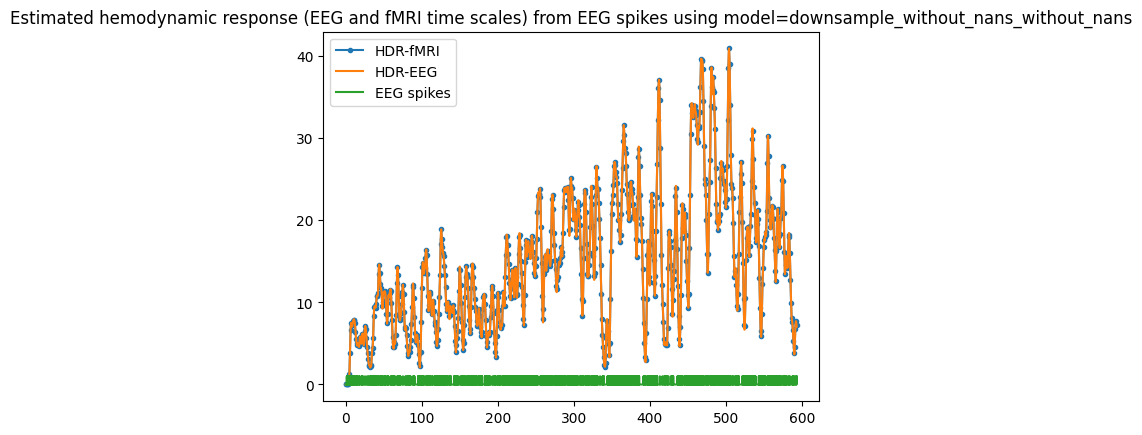

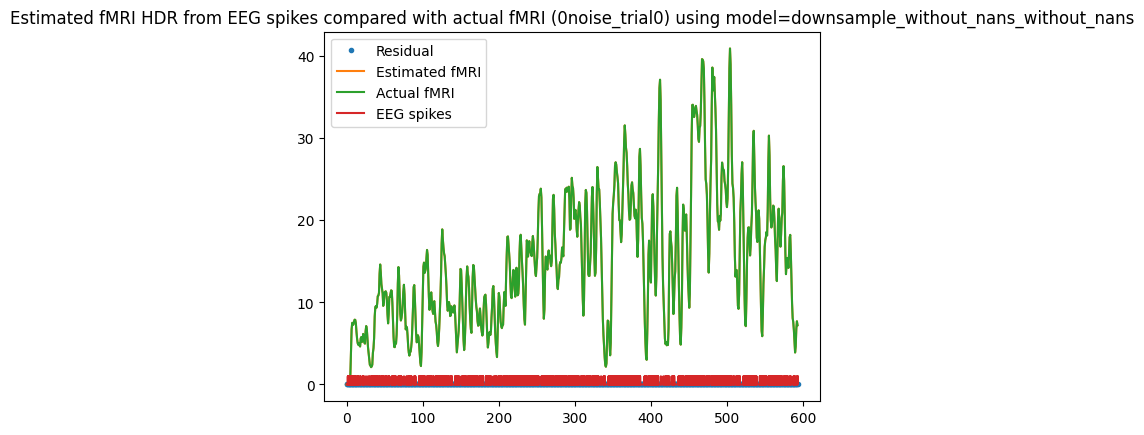

Residual Variance is 0.000000


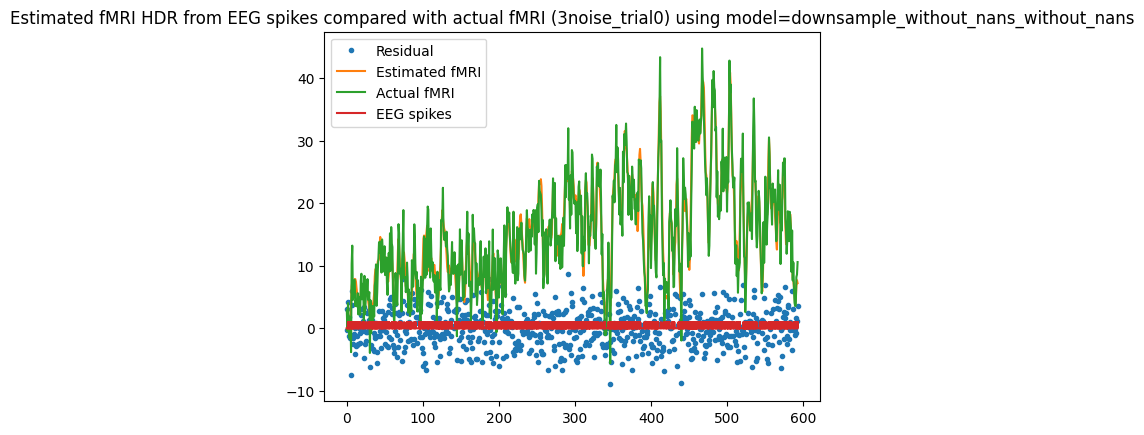

Residual Variance is 8.768261


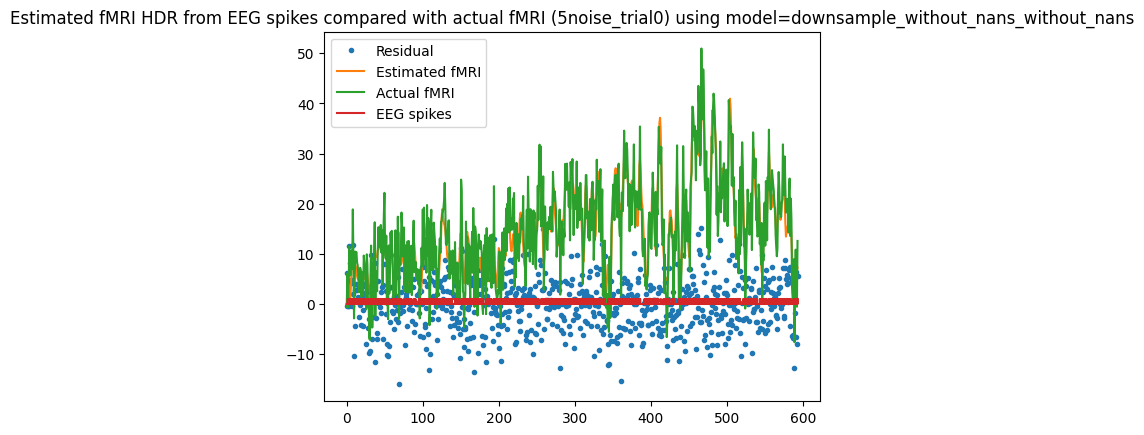

Residual Variance is 26.026514


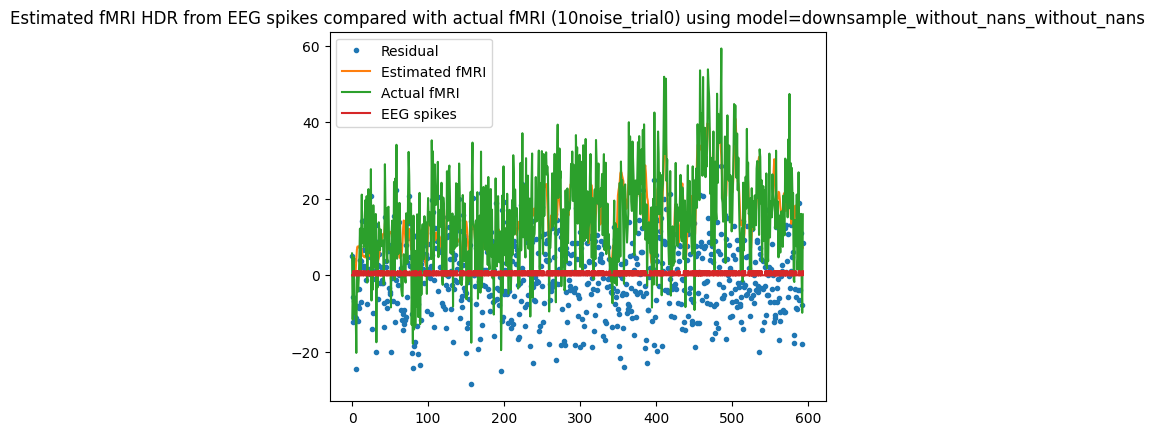

Residual Variance is 99.633584


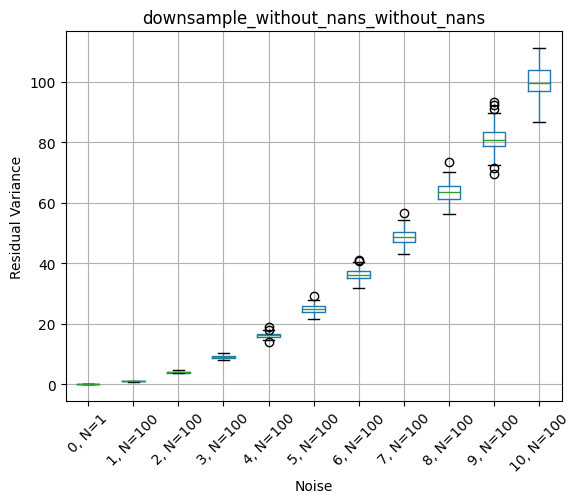

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.25, alpha=1.75


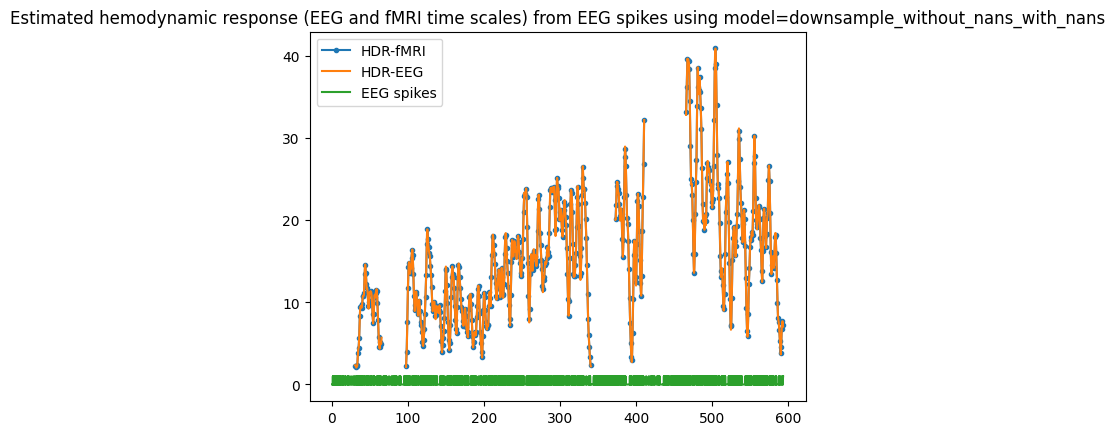

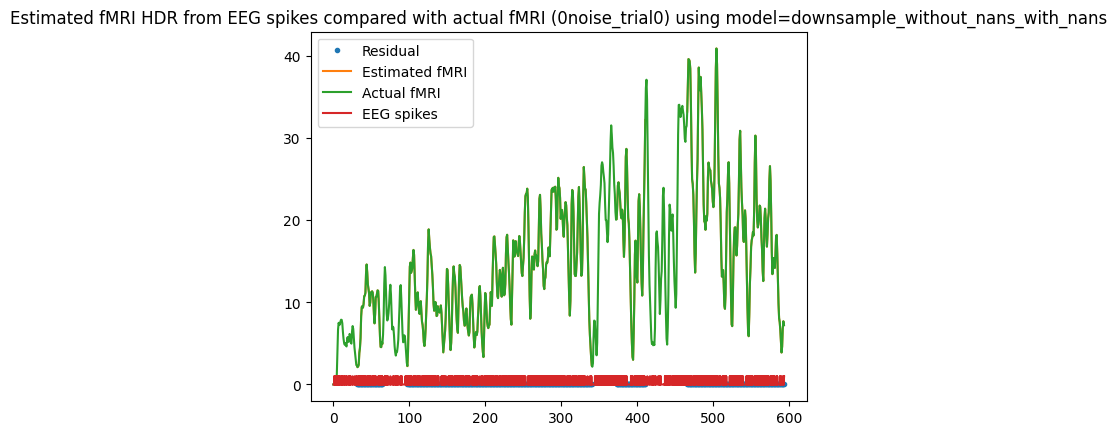

Residual Variance is 0.000000


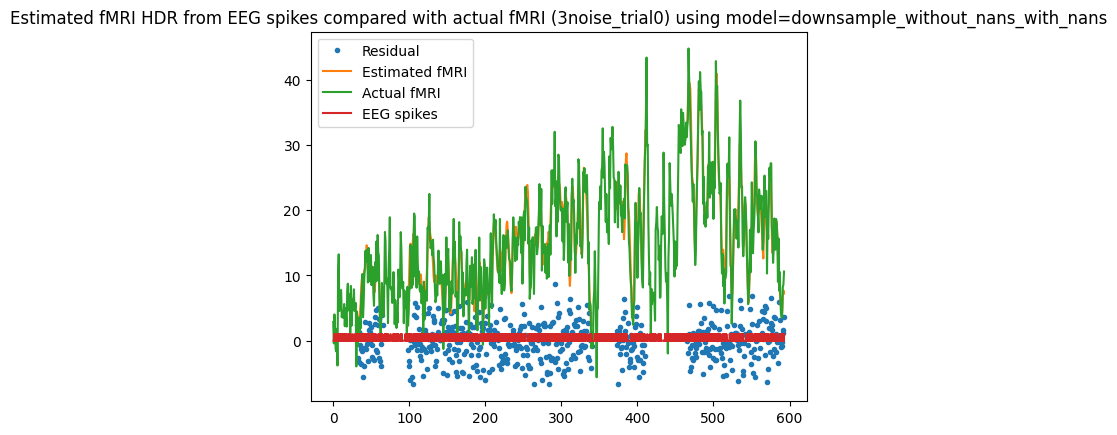

Residual Variance is 8.578940


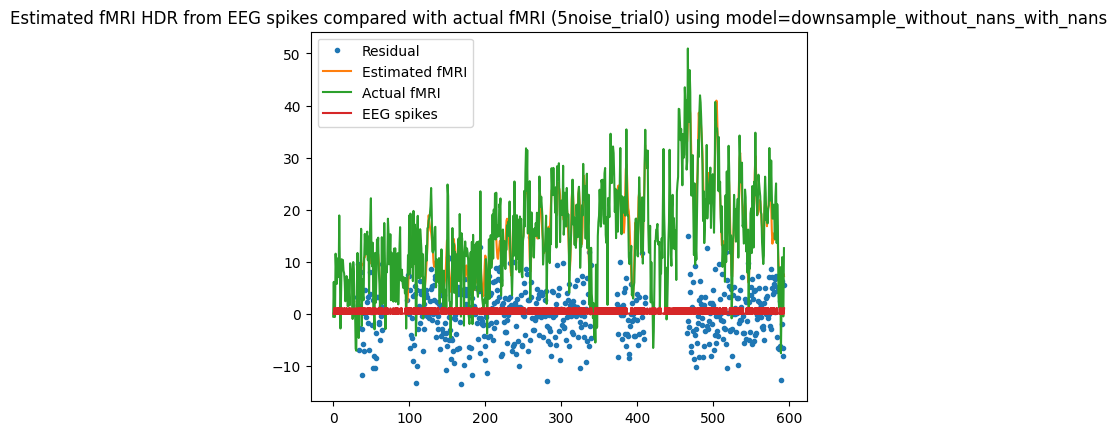

Residual Variance is 25.426268


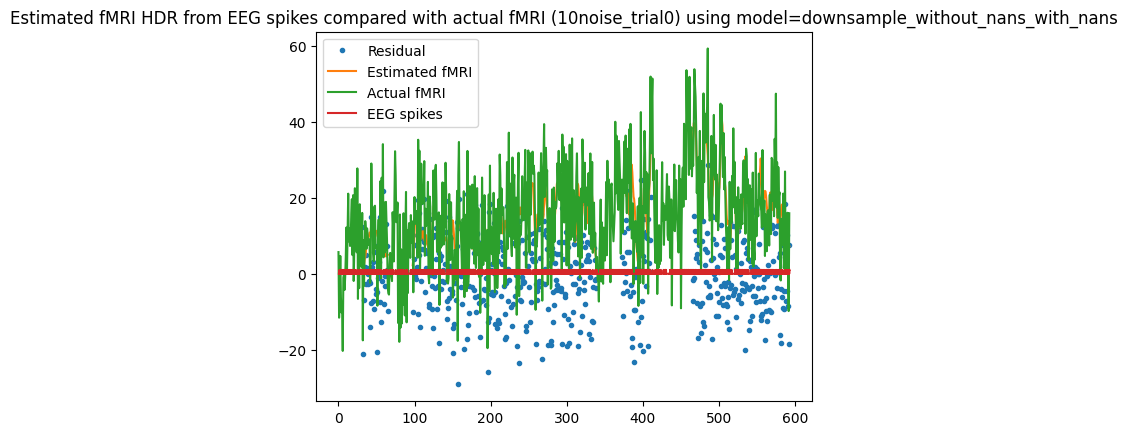

Residual Variance is 98.955974


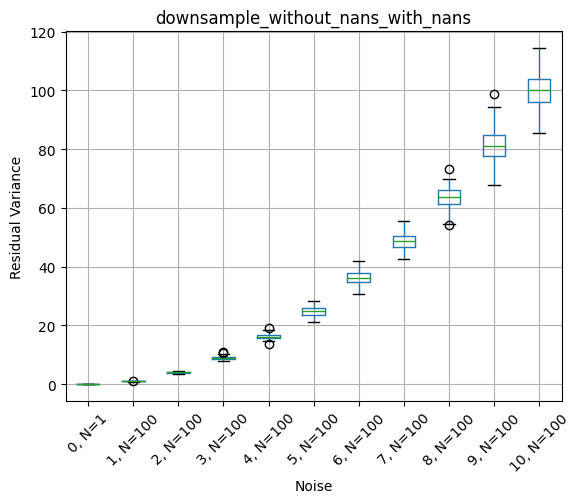

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   36.03569734298516   
1         downsample_without_nans_with_nans  33.261568893084814   
2      downsample_without_nans_without_nans  35.173463813438815   
3         downsample_without_nans_with_nans   32.50789116499385   
4      downsample_without_nans_without_nans  34.305764286377155   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans   16.60160734148029   
18938  downsample_without_nans_without_nans  18.744139649655686   
18939     downsample_without_nans_with_nans  17.244148625774674   
18940  downsample_without_nans_without_nans  19.466012668777985   
18941     downsample_without_nans_with_nans   17.87544256963081   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       36.28173942380546   42.26562407395023   46.12616292919201   
1        33.1110835113466  40.073485717684505  42.258488838593486   
2      35.445911333940266    41.3557437583677  45.281579798125954   
3       32.38936782632455    39.2602178065153   41.51924485243725   
4       34.60485299670754   40.43897121265974    44.4299253639884   
...                   ...                 ...                 ...   
18937  16.591921295652742   21.97047503145957  25.114651292149013   
18938  18.924439005509274  23.978695617277353   27.40434130747741   
18939   17.20698096760791  22.655314764078785  25.771461710685973   
18940  19.626180960362674   24.73418166719226  28.142625391428485   
18941  17.811802493032452  23.327497426956207   26.41631574464125   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0        52.0763150497546   60.36786561420848  ...   37.28520495753402   
1      51.245001501252354   58.64264606287673  ...   34.43127857739815   
2       51.16776864133008    59.5230661032922  ...   36.41555702791485   
3      50.433017291204514   57.89786703151441  ...   33.67516809710837   
4       50.25537041800356   58.67466547367744  ...  35.540410720658784   
...                   ...                 ...  ...                 ...   
18937  33.539473880738775  40.051819680891455  ...   17.42912032032985   
18938   34.81622475909286  43.464431662749035  ...  19.687776403133526   
18939  34.223907502906094   40.67134654066768  ...  18.068193636583942   
18940  35.550274966390546    44.1515951476612  ...  20.411395942532607   
18941   34.89639399464237  41.282894406242434  ...   18.69615830437784   

          2noise_trial99      3noise_trial99      4noise_trial99  \
0      40.42570168672731  43.550016996292676  51.036614276146544   
1      37.58711961056747   40.65120268087871  46.482886160050846   
2      39.55125535081717    42.6318734838423   50.24271953649304   
3      36.83035164805313   39.86712102561553   45.81297087434028   
4      38.67123707476102   41.70954402311576  49.442086946644935   
...                  ...                 ...                 ...   
18937  21.52809911216838  25.868430932068115  31.118988143426595   
18938  23.70911706992804   28.78786368480567  33.108721830447976   
18939   22.1817773865406  26.514531102913704   31.700291

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 9.880833044830088e-29; at
       delta   tau  alpha
11770   2.25  1.25   1.75


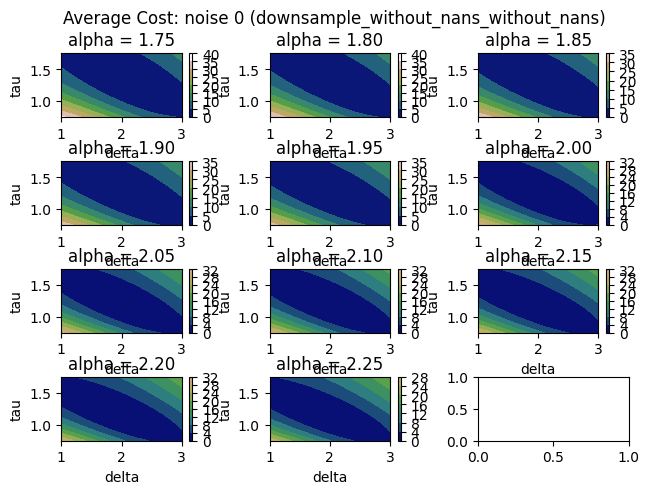

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              36.035697             
2                                              35.173464             
4                                              34.305764             
6                                              33.433451             
8                                              32.557393             
...                                                  ...             
18932                                          16.524892             
18934                                          17.272691             
18936                                          18.012753             
18938                                          18.744140             
18940                                          19.466013             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.75


delta   tau  alpha
0   2.25  1.25   1.75

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.75


noise iteration          cost  delta   tau  alpha
0      0         0  2.198902e-02   2.05  1.10   2.25
1      0         0  1.306100e-02   2.10  1.15   2.10
2      0         0  4.732955e-03   2.20  1.20   1.90
3      0         0  9.880833e-29   2.25  1.25   1.75

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         4.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration          cost  delta   tau  alpha
3      0         0  9.880833e-29   2.25  1.25   1.75

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration      cost  delta  tau  alpha
0      0         0  0.021989   2.05  1.1   2.25

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 9.691862343873556e-29; at
       delta   tau  alpha
11771   2.25  1.25   1.75


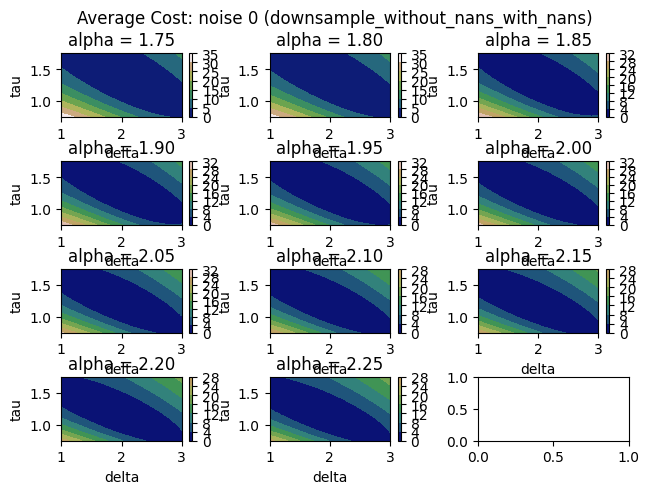

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              33.261569          
3                                              32.507891          
5                                              31.746634          
7                                              30.978541          
9                                              30.204385          
...                                                  ...          
18933                                          15.285694          
18935                                          15.948521          
18937                                          16.601607          
18939                                          17.244149          
18941                                          17.875443          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.75


delta   tau  alpha
0   2.25  1.25   1.75

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.75


noise iteration          cost  delta   tau  alpha
0      0         0  2.200010e-02   2.05  1.10   2.25
1      0         0  1.346690e-02   2.10  1.15   2.10
2      0         0  4.841204e-03   2.20  1.20   1.90
3      0         0  9.691862e-29   2.25  1.25   1.75

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         4.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration          cost  delta   tau  alpha
3      0         0  9.691862e-29   2.25  1.25   1.75

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration   cost  delta  tau  alpha
0      0         0  0.022   2.05  1.1   2.25

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9978748695483749; at
       delta   tau  alpha
11770   2.25  1.25   1.75


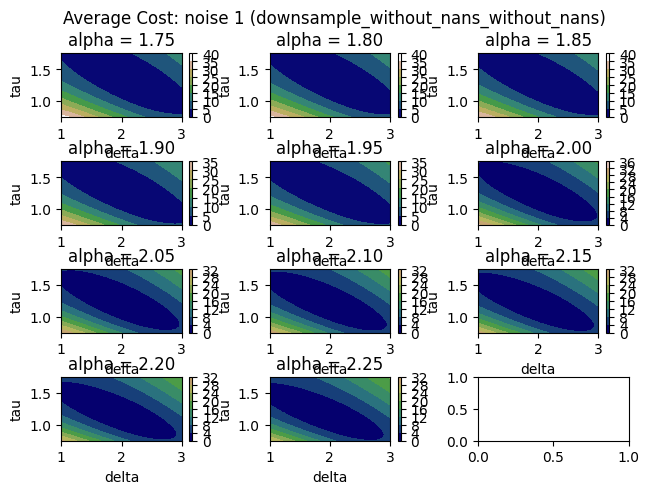

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 3.9920247838256655; at
       delta   tau  alpha
11770   2.25  1.25   1.75


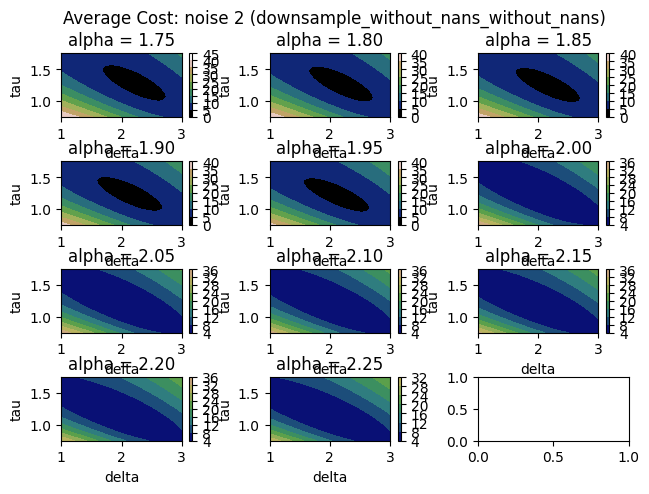

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.994280489324543; at
       delta   tau  alpha
11770   2.25  1.25   1.75


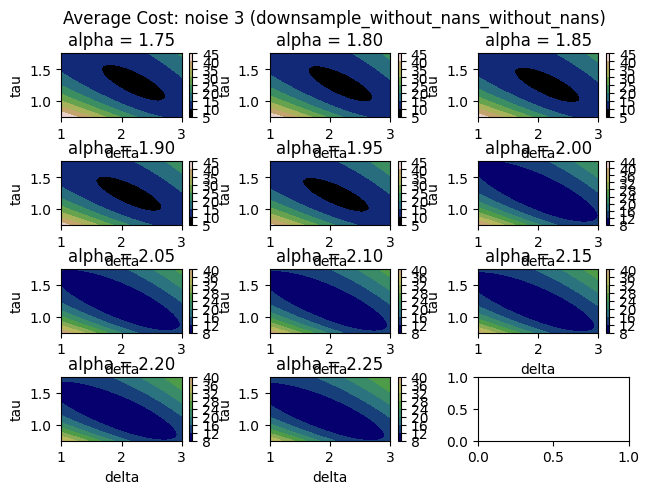

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.17783862515945; at
       delta   tau  alpha
11770   2.25  1.25   1.75


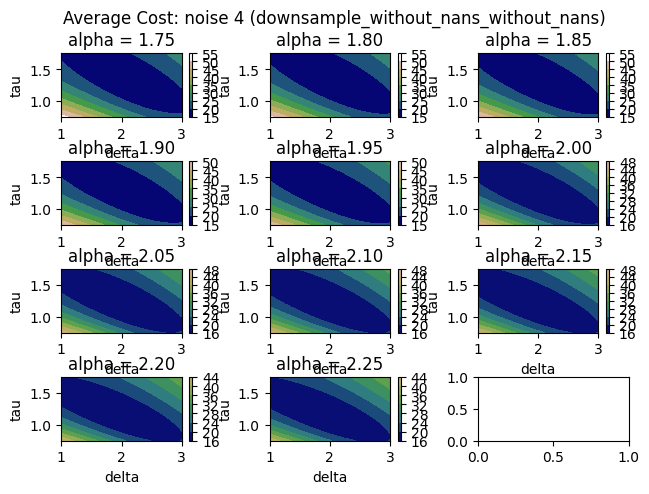

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 24.88114203909507; at
       delta   tau  alpha
11310    2.2  1.25    1.8


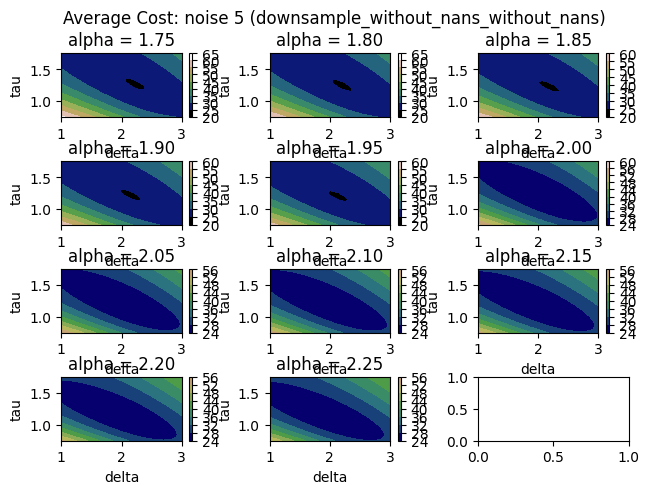

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.25428909804203; at
       delta   tau  alpha
11770   2.25  1.25   1.75


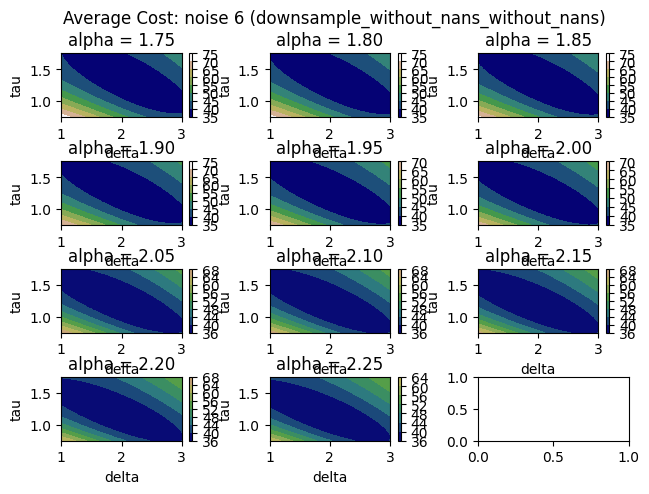

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.84998791133285; at
       delta   tau  alpha
11770   2.25  1.25   1.75


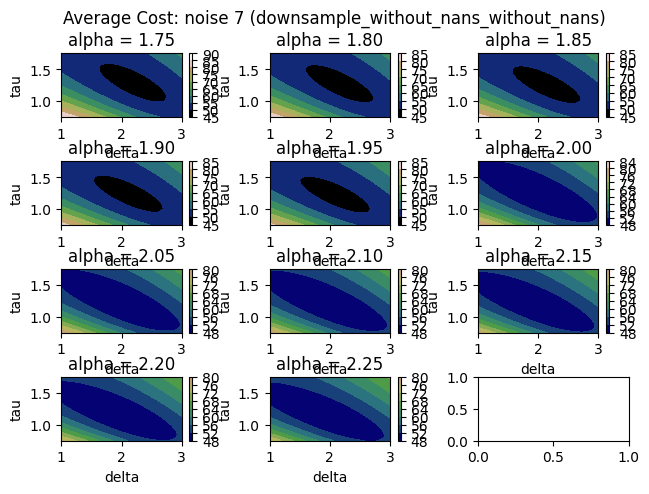

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.44000137830487; at
       delta   tau  alpha
11770   2.25  1.25   1.75


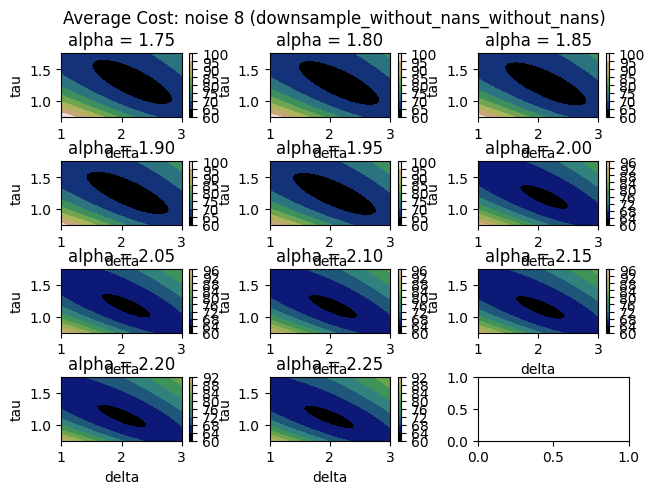

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.11472183951545; at
       delta   tau  alpha
11770   2.25  1.25   1.75


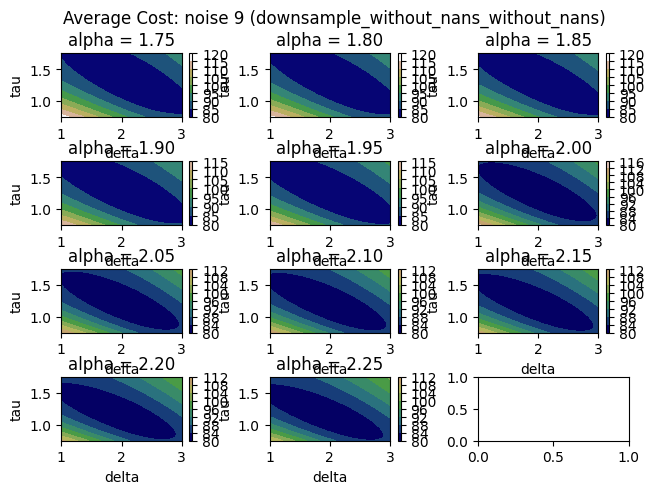

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 99.79089579949206; at
       delta  tau  alpha
11292    2.2  1.2    1.9


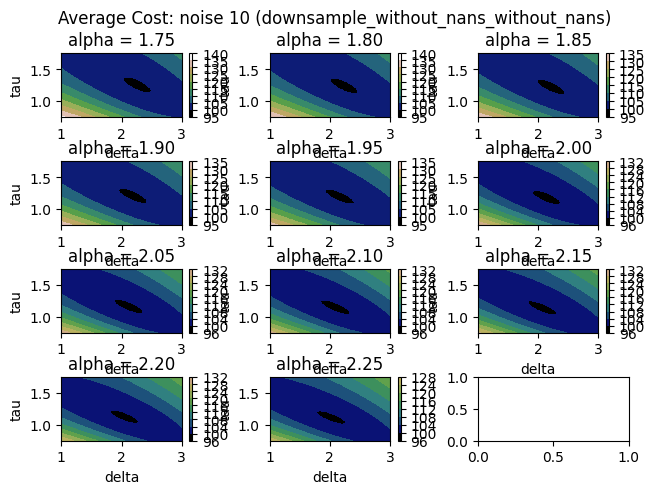

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

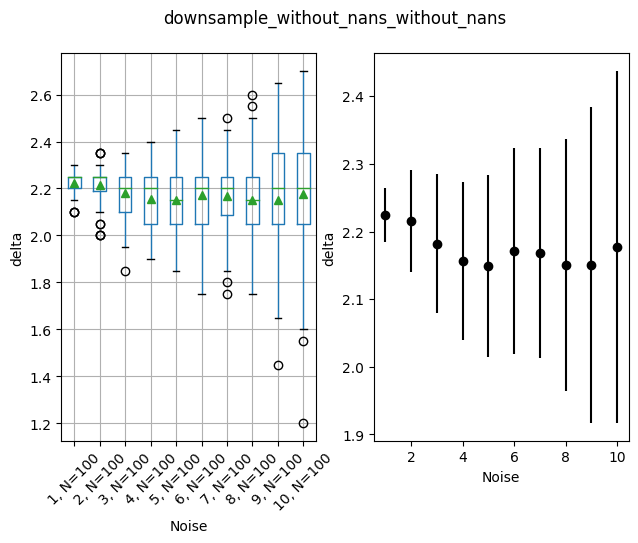

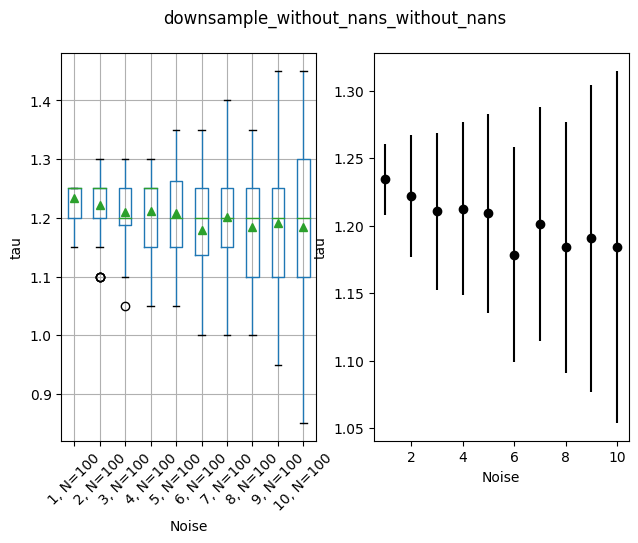

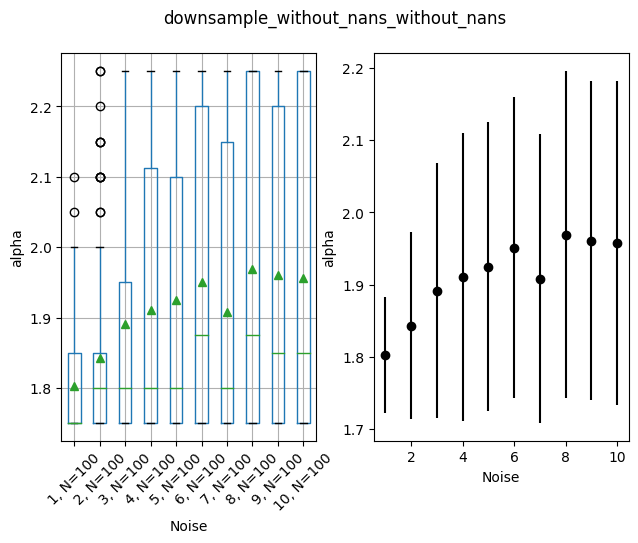

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 1.0042674466059751; at
       delta   tau  alpha
11771   2.25  1.25   1.75


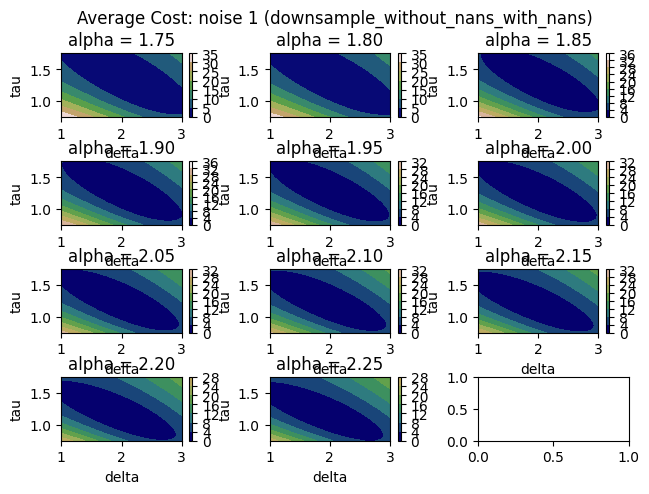

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 3.9812848749697496; at
       delta   tau  alpha
11771   2.25  1.25   1.75


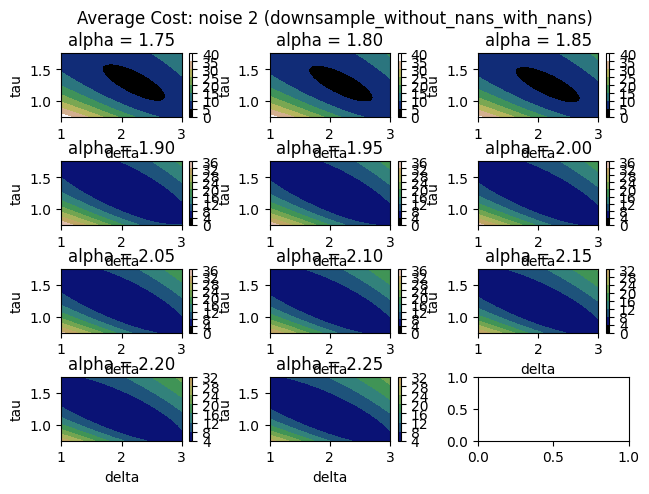

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.929987242120115; at
       delta   tau  alpha
11771   2.25  1.25   1.75


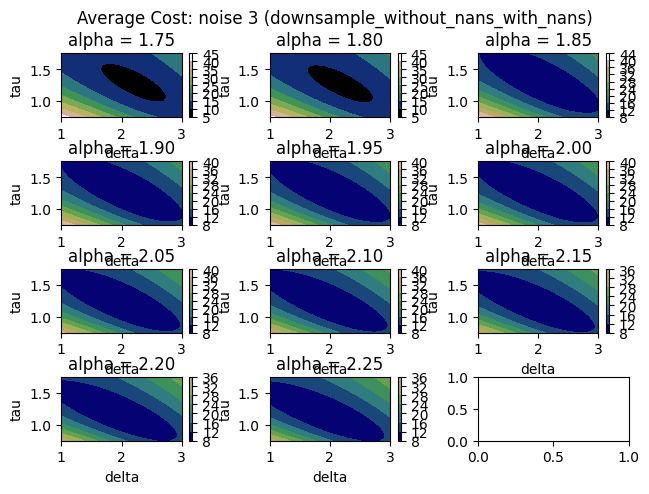

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 16.230426243588102; at
       delta   tau  alpha
11771   2.25  1.25   1.75


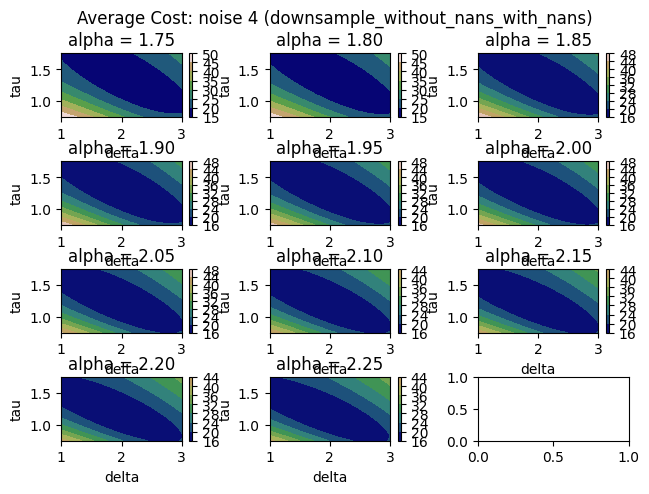

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 24.882043569064436; at
       delta   tau  alpha
11771   2.25  1.25   1.75


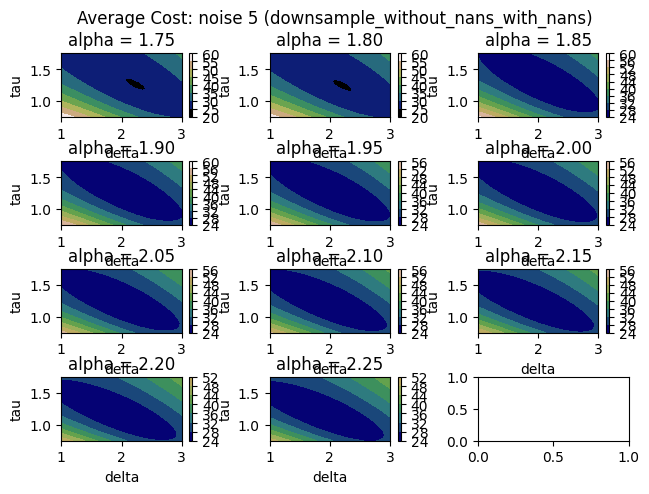

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.22682045397181; at
       delta   tau  alpha
11771   2.25  1.25   1.75


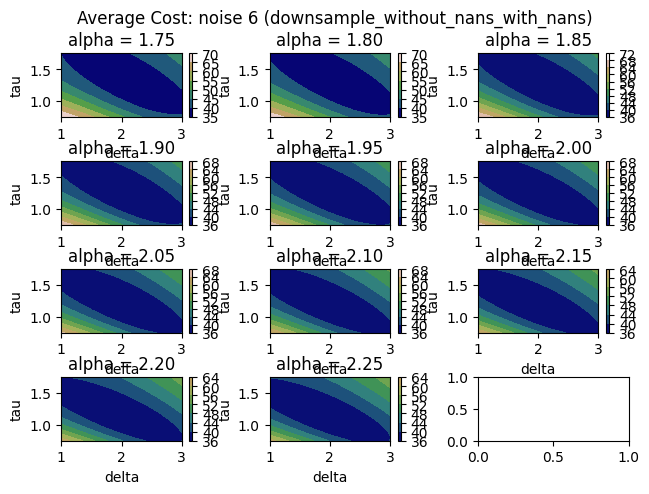

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.66833597985394; at
       delta   tau  alpha
11771   2.25  1.25   1.75


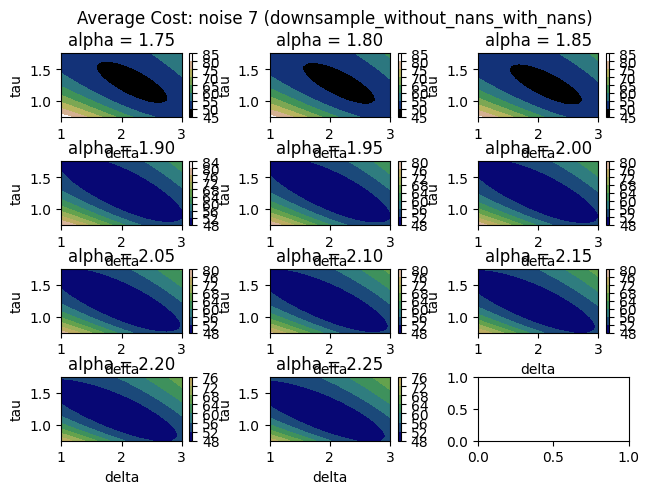

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.71410460490731; at
       delta   tau  alpha
11771   2.25  1.25   1.75


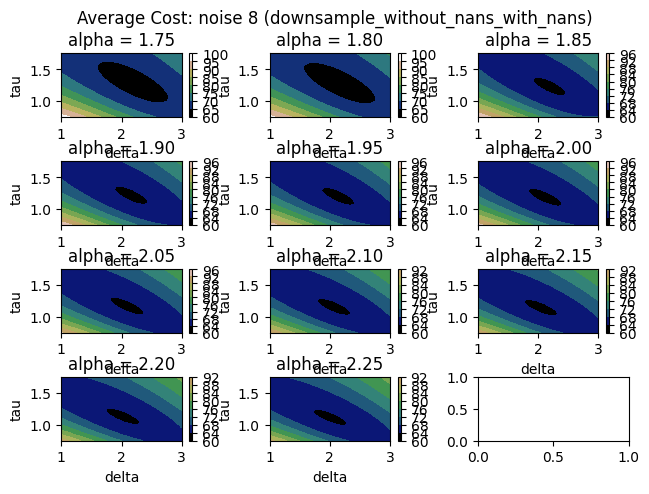

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 81.31704414704149; at
       delta   tau  alpha
11771   2.25  1.25   1.75


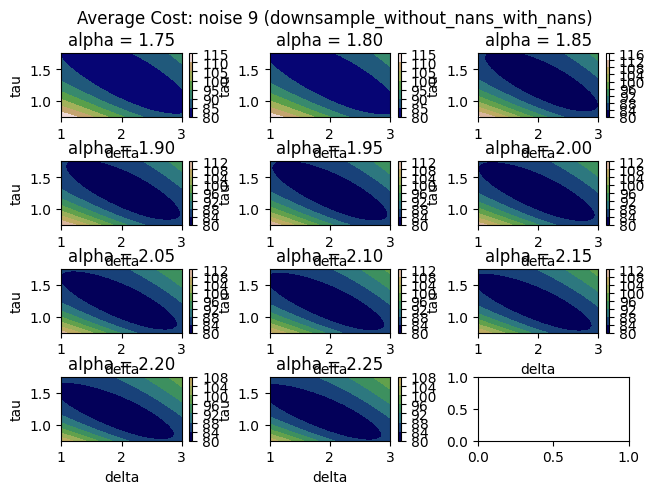

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 99.97806950965922; at
       delta  tau  alpha
11293    2.2  1.2    1.9


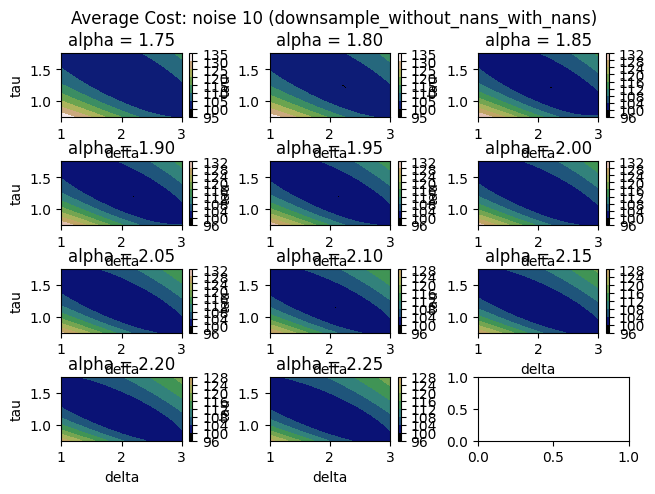

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


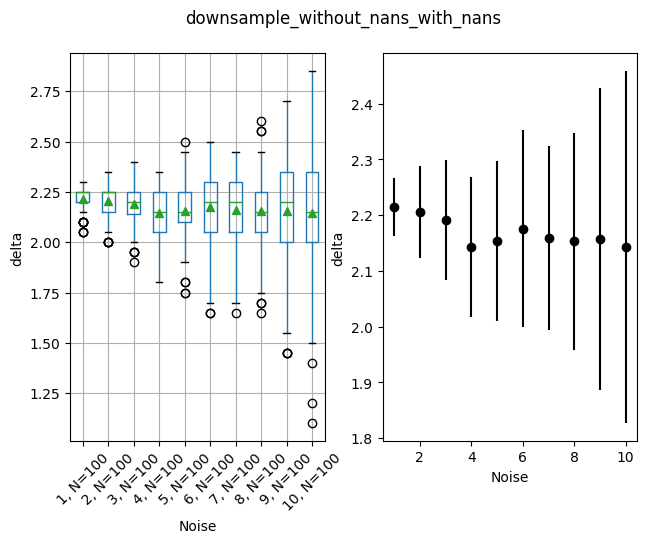

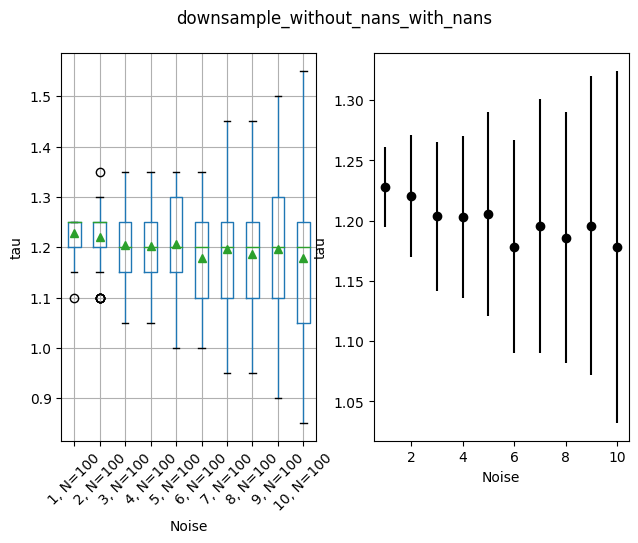

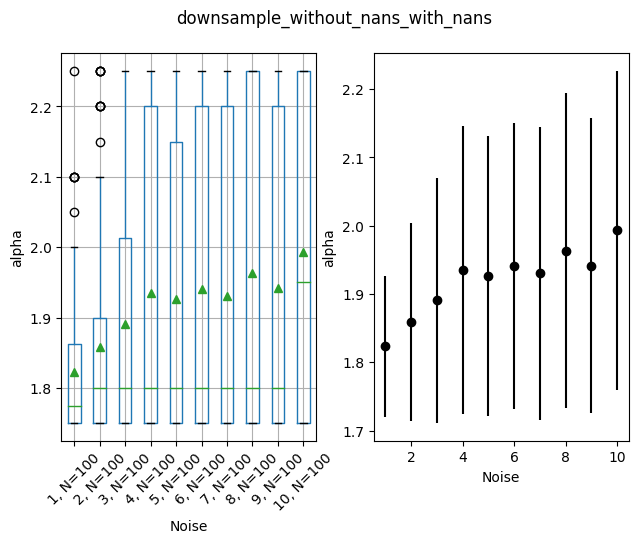

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        16    1.106166   2.000000000000001  1.1000000000000003   
1         1        36    0.938832   2.000000000000001  1.1000000000000003   
2         1        50    0.987343   2.000000000000001  1.1000000000000003   
3         1        51    1.045498   2.000000000000001  1.1000000000000003   
4         1        56    1.021761   2.000000000000001  1.1000000000000003   
...     ...       ...         ...                 ...                 ...   
2663     10        53   89.865392  2.6500000000000012  1.1000000000000003   
2664     10        79  102.923839  2.7000000000000015  1.0500000000000003   
2665     10        51  103.419841  2.7000000000000015  1.0500000000000003   
2666     10        64  103.196587  2.7500000000000018  0.9500000000000002   
2667     10        51  103.421773  2.8000000000000016  1.1000000000000003   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2663                1.75  
2664                1.75  
2665  1.9500000000000002  
2666                 1.8  
2667                1.75  

[2668 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  3.55  0.609272  1.0  3.0  4.0  4.00  4.0
2                      100.0  3.18  0.770412  1.0  3.0  3.0  4.00  4.0
3                      100.0  3.02  0.875941  1.0  3.0  3.0  4.00  4.0
4                      100.0  2.59  1.035677  1.0  2.0  3.0  3.00  4.0
5                      100.0  2.62  1.089713  1.0  2.0  3.0  3.00  4.0
6                      100.0  2.64  1.039814  1.0  2.0  3.0  3.00  4.0
7                      100.0  2.51  1.176324  1.0  1.0  3.0  3.25  4.0
8                      100.0  2.13  1.116045  1.0  1.0  2.0  3.00  4.0
9                      100.0  2.32  1.090640  1.0  1.0  2.0  3.00  5.0
10                     100.0  2.12  1.139555  1.0  1.0  2.0  3.00  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
252       1        73    0.934353   2.200000000000001  1.2500000000000004   
281       1         3    1.054004   2.250000000000001  1.2500000000000004   
282       1         4    1.027245   2.250000000000001  1.2500000000000004   
283       1         6    1.025924   2.250000000000001  1.2500000000000004   
284       1         7    1.059889   2.250000000000001  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
2657     10        37  103.736706  2.5500000000000016  1.0500000000000003   
2658     10        96   92.162348  2.5500000000000016  1.2000000000000004   
2663     10        53   89.865392  2.6500000000000012  1.1000000000000003   
2664     10        79  102.923839  2.7000000000000015  1.0500000000000003   
2667     10        51  103.421773  2.8000000000000016  1.1000000000000003   

     alpha  
252   1.75  
281   1.75  
282   1.75  
283   1.75  
284   1.75  
...    ...  
2657  1.75  
2658  1.75  
2663  1.75  
2664  1.75  
2667  1.75  

[581 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        74      3   2.250000000000001   72    74      1  1.2500000000000004   
10       55     18  2.1500000000000012    8    55     10  1.2500000000000004   
2        54      5   2.250000000000001   33    54      3  1.2500000000000004   
3        56      6   2.250000000000001   20    56      3  1.2500000000000004   
4        53      8   2.200000000000001   16    53      3  1.2500000000000004   
5        58      9   2.300000000000001   12    58      5  1.3000000000000005   
6        58     10  2.3500000000000014   12    58      6  1.2000000000000004   
7        64     11   2.200000000000001   14    64      7  1.2500000000000004   
8        52     13  2.3500000000000014   10    52      7  1.3000000000000005   
9        57     15   2.250000000000001   10    57     10  1.3000000000000005   

            
      freq  
noise       
1       74  
10       9  
2       40  
3       38  
4       34  
5       24  
6       19  
7       18  
8       14  
9       12

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        16    1.106166   2.000000000000001  1.1000000000000003   
1         1        36    0.938832   2.000000000000001  1.1000000000000003   
2         1        50    0.987343   2.000000000000001  1.1000000000000003   
3         1        51    1.045498   2.000000000000001  1.1000000000000003   
4         1        56    1.021761   2.000000000000001  1.1000000000000003   
...     ...       ...         ...                 ...                 ...   
2602     10        67  101.263759   2.300000000000001  1.0000000000000002   
2604     10        77  107.851844   2.300000000000001  1.0500000000000003   
2614     10        76  101.328548  2.3500000000000014  0.9000000000000001   
2631     10        56  102.459305  2.4000000000000012  1.0500000000000003   
2659     10        64  103.190096  2.6000000000000014  0.8500000000000001   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2602  2.2500000000000004  
2604  2.2500000000000004  
2614  2.2500000000000004  
2631  2.2500000000000004  
2659  2.2500000000000004  

[348 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        53      2  2.0500000000000007   46    53      1  1.1000000000000003   
10       39     18   2.100000000000001    6    39     11  1.1000000000000003   
2        22      4  2.0500000000000007   14    22      3  1.1000000000000003   
3        32      8   2.000000000000001    9    32      3  1.1000000000000003   
4        27      6  2.0500000000000007    9    27      3  1.1000000000000003   
5        31      7  2.0500000000000007    8    31      3  1.1500000000000004   
6        37     11  2.1500000000000012    8    37      5  1.0500000000000003   
7        36     12  1.9500000000000008    8    36      6  1.1000000000000003   
8        38     11  2.1500000000000012    7    38      7  1.1000000000000003   
9        33     17   2.200000000000001    4    33      9  1.1500000000000004   

            
      freq  
noise       
1       53  
10      10  
2       20  
3       20  
4       12  
5       14  
6       14  
7       11  
8       14  
9        8

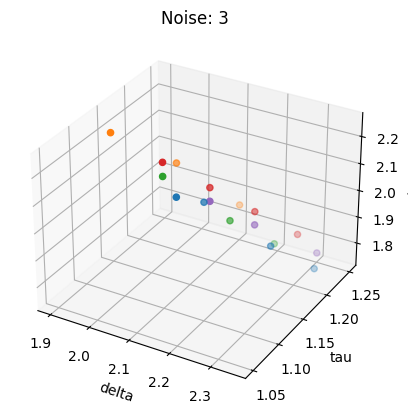

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

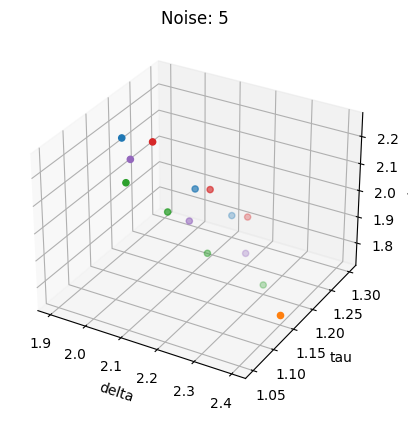

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

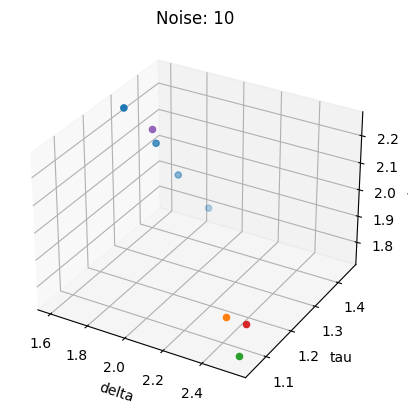

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration       cost               delta                 tau  \
0         1         9   1.088634   2.000000000000001  1.1000000000000003   
1         1        16   1.128137   2.000000000000001  1.1000000000000003   
2         1        36   0.970139   2.000000000000001  1.1000000000000003   
3         1        38   1.088990   2.000000000000001  1.1000000000000003   
4         1        50   1.011133   2.000000000000001  1.1000000000000003   
...     ...       ...        ...                 ...                 ...   
2507     10        96  88.733017  2.6500000000000012  1.1000000000000003   
2508     10        53  91.569320  2.6500000000000012  1.1000000000000003   
2509     10        78  93.737214  2.7000000000000015  1.0000000000000002   
2510     10        45  88.757361  2.8000000000000016  1.1500000000000004   
2511     10        79  96.685522  2.8500000000000014  1.0000000000000002   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2507                1.75  
2508                 1.8  
2509                1.75  
2510                1.75  
2511                1.75  

[2512 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.41  0.766667  1.0  3.0  4.0  4.0  4.0
2                      100.0  3.16  0.837505  1.0  3.0  3.0  4.0  4.0
3                      100.0  2.88  1.037479  1.0  2.0  3.0  4.0  4.0
4                      100.0  2.41  1.092629  1.0  1.0  3.0  3.0  4.0
5                      100.0  2.56  1.057155  1.0  2.0  3.0  3.0  4.0
6                      100.0  2.38  1.051982  1.0  1.0  3.0  3.0  4.0
7                      100.0  2.30  1.167748  1.0  1.0  2.0  3.0  4.0
8                      100.0  1.97  1.114233  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.00  1.063632  1.0  1.0  2.0  3.0  4.0
10                     100.0  2.05  1.122542  1.0  1.0  2.0  3.0  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
239       1        50    0.977334   2.200000000000001  1.2500000000000004   
269       1         3    1.091717   2.250000000000001  1.2500000000000004   
270       1         4    1.075801   2.250000000000001  1.2500000000000004   
271       1         6    1.018074   2.250000000000001  1.2500000000000004   
272       1         7    1.086057   2.250000000000001  1.2500000000000004   
...     ...       ...         ...                 ...                 ...   
2502     10        39  105.028168  2.6000000000000014  1.1000000000000003   
2507     10        96   88.733017  2.6500000000000012  1.1000000000000003   
2509     10        78   93.737214  2.7000000000000015  1.0000000000000002   
2510     10        45   88.757361  2.8000000000000016  1.1500000000000004   
2511     10        79   96.685522  2.8500000000000014  1.0000000000000002   

     alpha  
239   1.75  
269   1.75  
270   1.75  
271   1.75  
272   1.75  
...    ...  
2502  1.75  
2507  1.75  
2509  1.75  
2510  1.75  
2511  1.75  

[567 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                  tau                             \
      count unique                top freq count unique                 top   
noise                                                                         
1        71      3  2.250000000000001   69    71      1  1.2500000000000004   
10       52     21  2.250000000000001    6    52     11  1.2500000000000004   
2        65      5  2.250000000000001   28    65      4  1.2500000000000004   
3        59      7  2.250000000000001   16    59      5  1.2500000000000004   
4        53      6  2.250000000000001   15    53      5  1.2500000000000004   
5        50     10  2.200000000000001   10    50      6  1.3000000000000005   
6        57     11  2.300000000000001   12    57      8  1.2500000000000004   
7        57     12  2.250000000000001   12    57      8  1.2500000000000004   
8        51     13  2.200000000000001    9    51      8  1.2000000000000004   
9        52     18  2.250000000000001    5    52     11  1.3000000000000005   

            
      freq  
noise       
1       71  
10      10  
2       47  
3       34  
4       29  
5       16  
6       21  
7       15  
8       12  
9       11

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1         9    1.088634   2.000000000000001  1.1000000000000003   
1         1        16    1.128137   2.000000000000001  1.1000000000000003   
2         1        36    0.970139   2.000000000000001  1.1000000000000003   
3         1        38    1.088990   2.000000000000001  1.1000000000000003   
4         1        50    1.011133   2.000000000000001  1.1000000000000003   
...     ...       ...         ...                 ...                 ...   
2481     10        66   98.912642   2.450000000000001  0.9000000000000001   
2483     10        45   88.690553   2.450000000000001  1.0500000000000003   
2493     10        64  101.913070  2.5500000000000016  0.8500000000000001   
2495     10        51  106.277374  2.5500000000000016  1.0000000000000002   
2506     10        51  106.264831  2.6500000000000012  0.9500000000000002   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2481  2.2500000000000004  
2483  2.2500000000000004  
2493  2.2500000000000004  
2495  2.2500000000000004  
2506  2.2500000000000004  

[357 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        45      2  2.0500000000000007   36    45      1  1.1000000000000003   
10       51     25   2.200000000000001    6    51     12  1.0500000000000003   
2        27      4  2.0500000000000007   17    27      3  1.1000000000000003   
3        32      8   2.000000000000001    9    32      4  1.1000000000000003   
4        31      7   2.000000000000001   11    31      4  1.1000000000000003   
5        29      9   2.100000000000001    8    29      5  1.1000000000000003   
6        29     12  2.1500000000000012    5    29      7  1.1000000000000003   
7        40     12  2.0500000000000007    7    40      7  1.1000000000000003   
8        44     14   2.100000000000001    7    44      7  1.1000000000000003   
9        29     18  1.8500000000000008    3    29     10  1.0000000000000002   

            
      freq  
noise       
1       45  
10      14  
2       23  
3       19  
4       15  
5       10  
6        8  
7       11  
8       15  
9        9

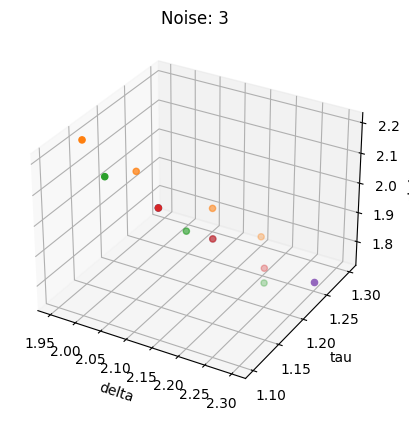

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

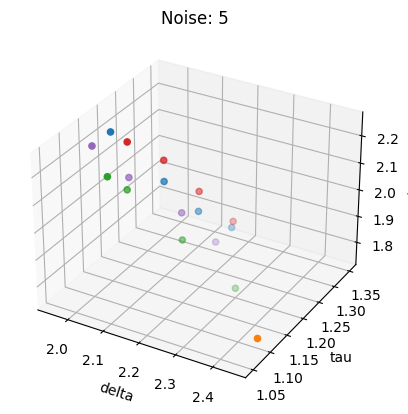

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

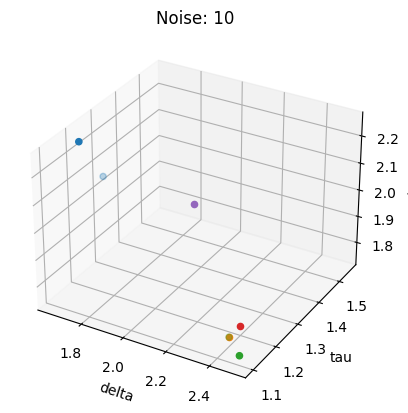

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()